Using device: cuda

Final Test Accuracy on Dataset A (MNIST): 10.00%
Final Test Accuracy on Dataset B (FashionMNIST): 56.00%

Final Test Accuracy on Dataset A (MNIST): 34.00%
Final Test Accuracy on Dataset B (FashionMNIST): 8.00%

Final Test Accuracy on Dataset A (MNIST): 11.00%
Final Test Accuracy on Dataset B (FashionMNIST): 45.00%

Final Test Accuracy on Dataset A (MNIST): 31.00%
Final Test Accuracy on Dataset B (FashionMNIST): 8.00%

Final Test Accuracy on Dataset A (MNIST): 8.00%
Final Test Accuracy on Dataset B (FashionMNIST): 38.00%

Final Test Accuracy on Dataset A (MNIST): 36.00%
Final Test Accuracy on Dataset B (FashionMNIST): 15.00%

Final Test Accuracy on Dataset A (MNIST): 18.00%
Final Test Accuracy on Dataset B (FashionMNIST): 44.00%

Final Test Accuracy on Dataset A (MNIST): 30.00%
Final Test Accuracy on Dataset B (FashionMNIST): 4.00%

Final Test Accuracy on Dataset A (MNIST): 13.00%
Final Test Accuracy on Dataset B (FashionMNIST): 51.00%

Final Test Accuracy on Dataset

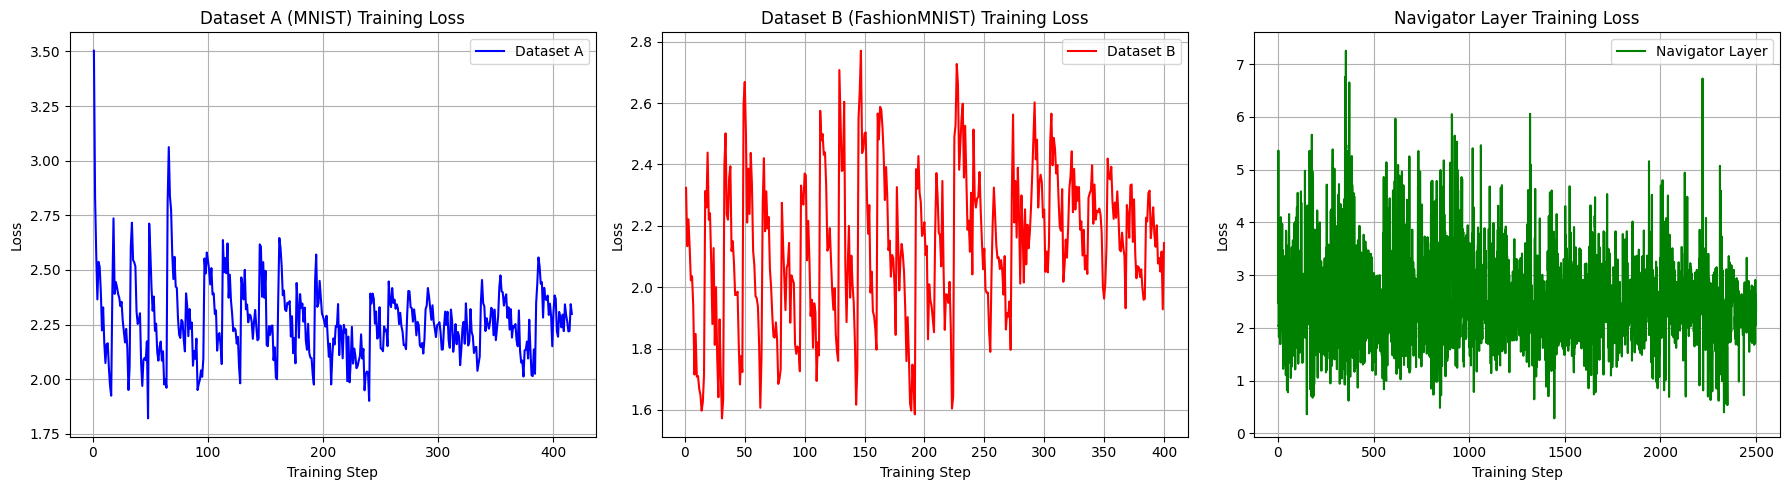

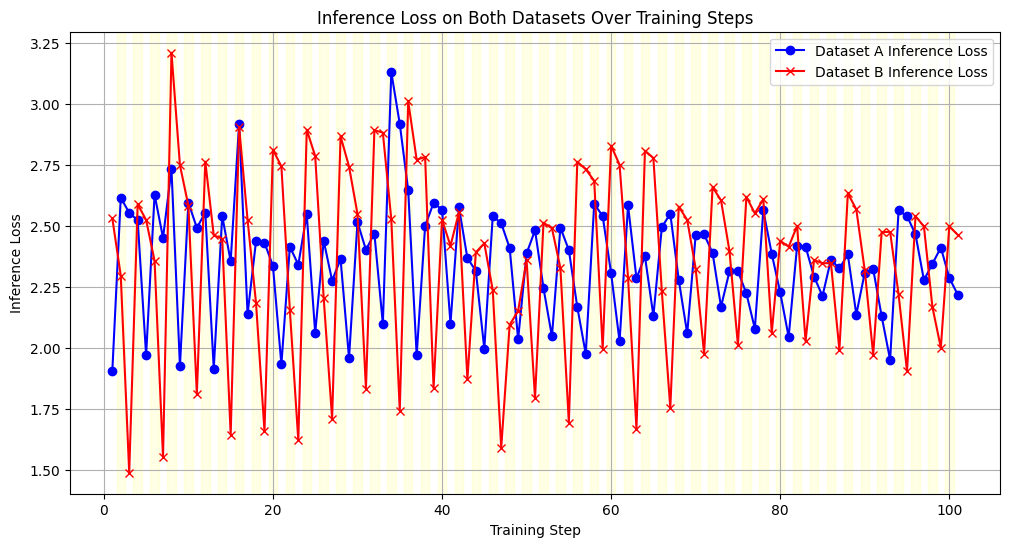

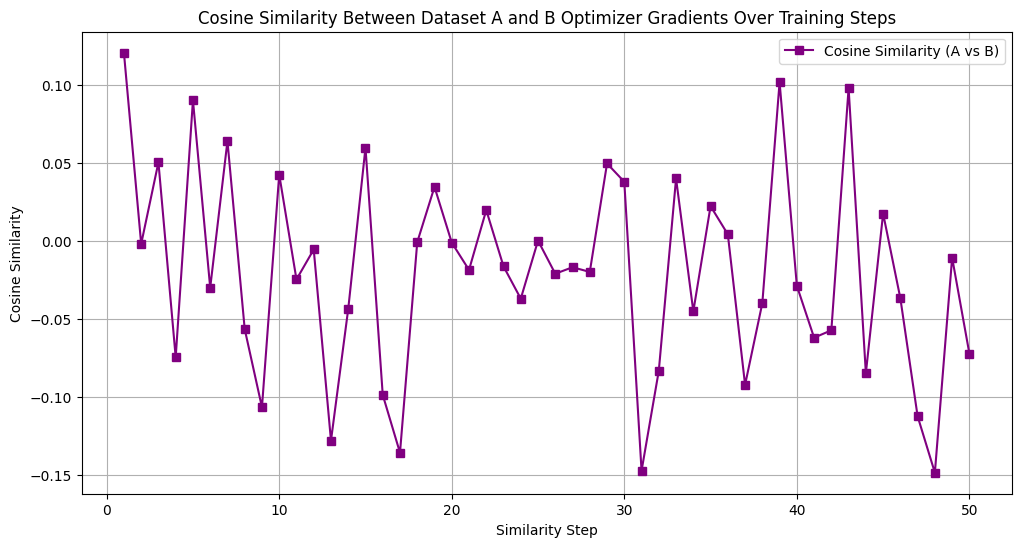

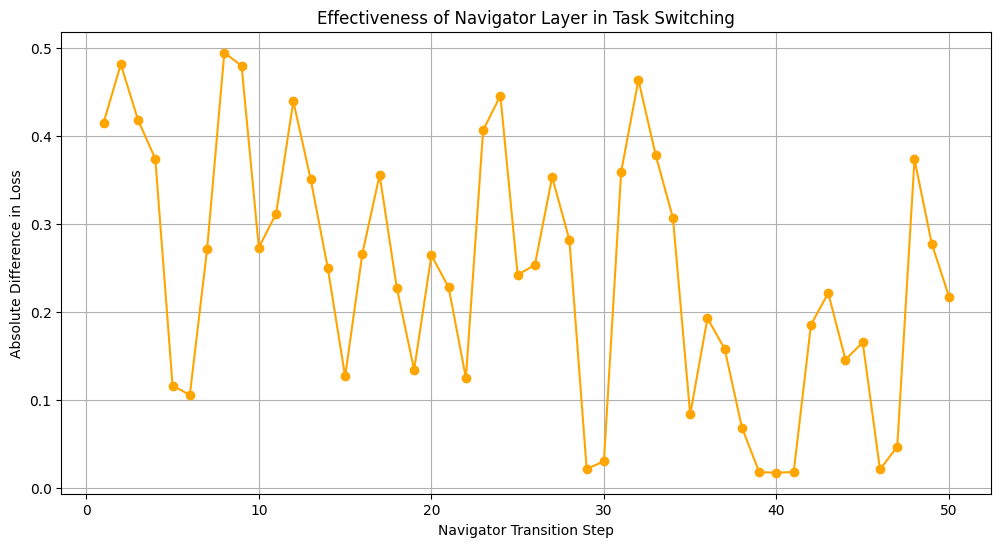

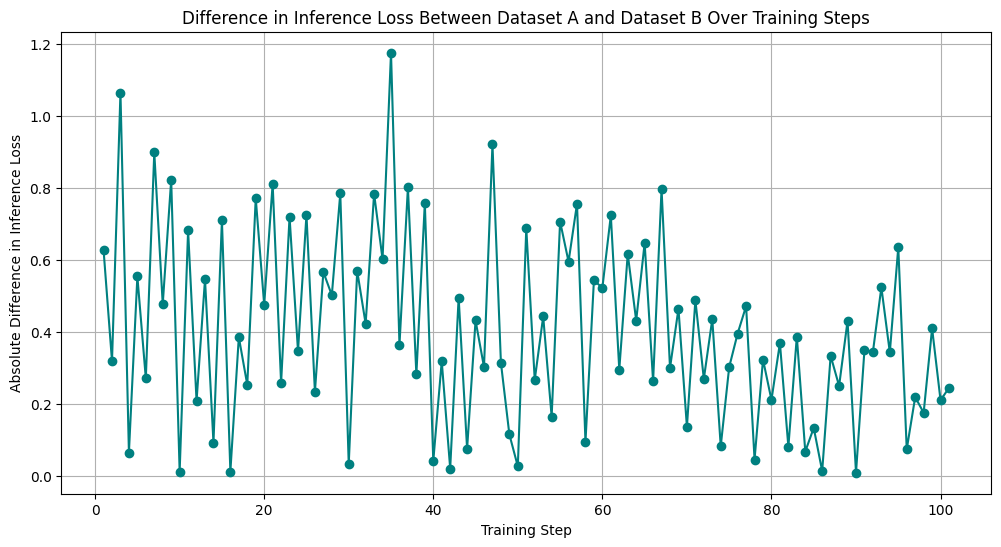


Average Training Loss for Dataset A (last 20 steps): 2.2785
Average Training Loss for Dataset B (last 20 steps): 2.1290
Ratio of Trainable to Random Parameters: 6.1634


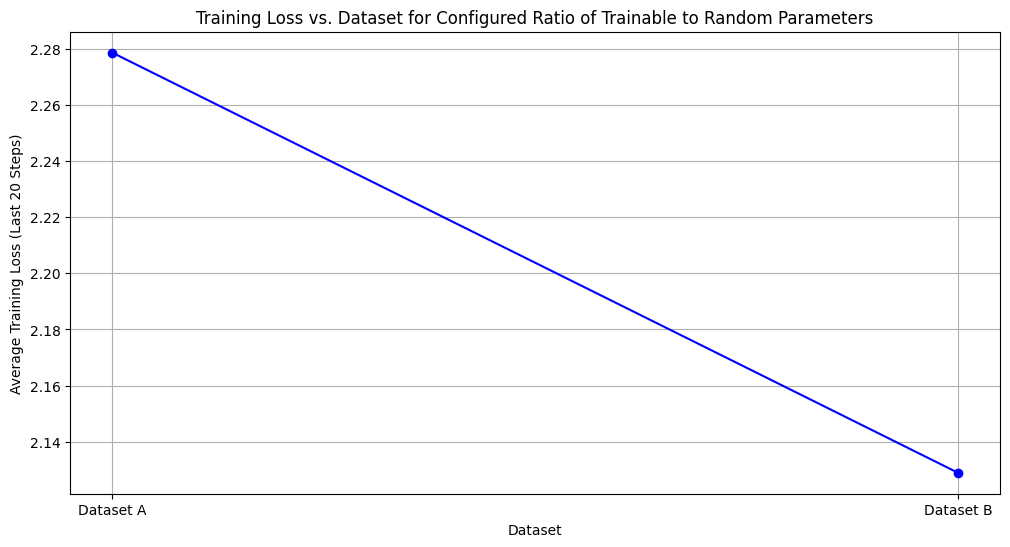

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# ===========================
# 1. Setup and Configuration
# ===========================

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration Parameters
batch_size = 64
subset_size = 1000  # Number of examples to use from each dataset for faster experiments
save_dir = "./saved_states"  # Directory to save the model and optimizer states
os.makedirs(save_dir, exist_ok=True)

# Hyperparameters for experiments
learning_rate_adam = 0.0001  # Learning rate for ADAM optimizers
learning_rate_sgd = 0.001     # Learning rate for SGD optimizer (no longer used)
num_epochs_initial = 1        # Number of epochs for initial training on Dataset A
num_iterations = 50           # Number of times to repeat the training loop

# ===========================
# 1.a. Configurable Parameters
# ===========================

# Configuration for Random Layers
num_random_layers = 1      # Number of randomized layers to add
random_layer_size = 128     # Size (number of neurons) of each randomized layer

# Configuration for Navigator Layers
num_navigator_layers = 1    # Number of navigator layers to add

# Flag to re-randomize the random layers during task switching
re_randomize = True         # Set to True to re-randomize, False to keep them fixed

# ===========================
# 2. Model Definition
# ===========================

class SimpleNet(nn.Module):
    """
    A simple neural network with configurable navigator layers and randomized layers.
    """
    def __init__(self, num_navigator_layers=1, num_random_layers=0, random_layer_size=128):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Add configurable navigator layers
        self.navigator_layers = nn.ModuleList()
        for _ in range(num_navigator_layers):
            nav_layer = nn.Linear(128, 128)
            self.navigator_layers.append(nav_layer)
            self.navigator_layers.append(nn.ReLU())
        
        # Add configurable random layers
        self.random_layers = nn.ModuleList()
        for _ in range(num_random_layers):
            rand_layer = nn.Linear(random_layer_size, random_layer_size)
            # Initialize with random weights and biases
            nn.init.normal_(rand_layer.weight)
            nn.init.normal_(rand_layer.bias)
            # Freeze the random layers
            for param in rand_layer.parameters():
                param.requires_grad = False
            self.random_layers.append(rand_layer)
            self.random_layers.append(nn.ReLU())
        
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        
        # Pass through navigator layers
        for layer in self.navigator_layers:
            x = layer(x)
        
        # Pass through random layers if any
        for layer in self.random_layers:
            x = layer(x)
        
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ===========================
# 3. Helper Functions
# ===========================

def load_subset_data(transform, dataset, subset_size=100):
    """
    Loads a subset of the specified dataset.
    """
    if dataset == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset == 'FashionMNIST':
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Unknown dataset {dataset}")
    
    train_subset = torch.utils.data.Subset(train_dataset, np.arange(subset_size))
    test_subset = torch.utils.data.Subset(test_dataset, np.arange(max(100, subset_size // 10)))  # Smaller test set
    
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def get_random_subset(dataset, fraction):
    """
    Returns a random subset of the dataset corresponding to the given fraction.
    """
    subset_size = int(len(dataset) * fraction)
    indices = np.random.choice(len(dataset), size=subset_size, replace=False)
    subset = torch.utils.data.Subset(dataset, indices)
    return subset

def get_flattened_gradients(params_to_include):
    """
    Extracts and flattens all gradients from the specified parameters into a single vector.
    """
    grads = []
    for param in params_to_include:
        if param.grad is not None:
            grads.append(param.grad.view(-1))
    if len(grads) == 0:
        return torch.zeros(1).to(device)
    return torch.cat(grads)

def train_model(model, train_loader, optimizer, criterion, num_epochs, device, collect_gradients=False, params_to_include=None):
    """
    Trains the model and records training loss per epoch and per step.
    Optionally collects and returns the flattened gradient vector.
    Returns a tuple of (epoch_losses, step_losses, gradient_vector or None).
    """
    model.train()
    epoch_losses = []
    step_losses = []
    gradient_vector = None
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            if collect_gradients and params_to_include is not None:
                gradient_vector = get_flattened_gradients(params_to_include).detach().clone()
            
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            step_losses.append(loss.item())
        
        epoch_loss /= len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
    return epoch_losses, step_losses, gradient_vector

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluates the model on the test set and records test loss and accuracy.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    return test_loss, accuracy

def reinitialize_random_layers(model):
    """
    Reinitializes the weights and biases of the randomized layers.
    """
    for layer in model.random_layers:
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight)
            nn.init.normal_(layer.bias)

# ===========================
# 4. Main Execution Loop
# ===========================

def main():
    # Define the transforms for the datasets
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load Dataset A (MNIST) and Dataset B (FashionMNIST)
    train_loader_A, test_loader_A = load_subset_data(transform, 'MNIST', subset_size=subset_size)
    train_loader_B, test_loader_B = load_subset_data(transform, 'FashionMNIST', subset_size=subset_size)
    
    # Initialize model with the configured number of navigator and random layers
    model = SimpleNet(num_navigator_layers=num_navigator_layers, num_random_layers=num_random_layers, random_layer_size=random_layer_size).to(device)
    
    # Define the criterion
    criterion = nn.CrossEntropyLoss()
    
    # Collect parameters
    # Exclude random layers from trainable parameters
    params_except_navigator = [param for name, param in model.named_parameters() if 'navigator_layer' not in name and 'random_layers' not in name]
    params_navigator = [param for name, param in model.named_parameters() if 'navigator_layer' in name]
    
    # ===========================
    # 4.a. Define Optimizers
    # ===========================
    
    # Updated Optimizer Definitions:
    # Combine main parameters and navigator layers into a single optimizer per dataset
    optimizer_A = optim.Adam(params_except_navigator + params_navigator, lr=learning_rate_adam)
    optimizer_B = optim.Adam(params_except_navigator + params_navigator, lr=learning_rate_adam)
    
    # Remove the separate optimizer for navigator layers
    # optimizer_navigator = optim.SGD(params_navigator, lr=learning_rate_sgd)  # Removed
    
    # Initialize lists to store losses and cosine similarities
    individual_losses_A = []
    individual_losses_B = []
    individual_losses_navigator = []
    inference_losses_A = []
    inference_losses_B = []
    cosine_similarities = []
    training_steps = []
    training_phases = []
    
    step_counter = 1  # To index training steps for plotting
    last_grad_A = None
    last_grad_B = None
    
    # Step 2: Freeze the navigator layers and train on Dataset A
    for param in params_navigator:
        param.requires_grad = False
    # Training on Dataset A
    epoch_loss_A, step_loss_A, grad_A = train_model(
        model, 
        train_loader_A, 
        optimizer_A, 
        criterion, 
        num_epochs_initial, 
        device, 
        collect_gradients=True, 
        params_to_include=params_except_navigator
    )
    
    # Store the individual training loss for Dataset A
    individual_losses_A.extend(step_loss_A)
    
    # Store the last gradient from Dataset A
    last_grad_A = grad_A
    
    # Record inference loss after initial training
    if last_grad_A is not None:
        test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
        test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
        inference_losses_A.append(test_loss_A)
        inference_losses_B.append(test_loss_B)
        training_steps.append(step_counter)
        training_phases.append('Dataset A')
        step_counter += 1
    
    # Repeat the custom training loop
    for iteration in range(num_iterations):
        if iteration % 2 == 0:
            # Step 3: Freeze all layers except the navigator layers
            for param in params_except_navigator:
                param.requires_grad = False
            for param in params_navigator:
                param.requires_grad = True

            # Optional: Re-randomize the random layers if the flag is set
            if re_randomize:
                reinitialize_random_layers(model)
            
            # Step 4: Train on a random 5% of Dataset B (Navigator Layer)
            subset_B = get_random_subset(train_loader_B.dataset, fraction=0.05)
            loader_B_subset = torch.utils.data.DataLoader(subset_B, batch_size=1, shuffle=True)
            epoch_loss_nav, step_loss_nav, _ = train_model(
                model, 
                loader_B_subset, 
                optimizer_B,  # Use optimizer_B instead of optimizer_navigator
                criterion, 
                1, 
                device, 
                collect_gradients=False
            )
            
            # Store the individual training loss for Navigator
            individual_losses_navigator.extend(step_loss_nav)
            
            # Record inference loss after navigator training
            test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
            test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
            inference_losses_A.append(test_loss_A)
            inference_losses_B.append(test_loss_B)
            training_steps.append(step_counter)
            training_phases.append('Navigator')
            step_counter += 1
            
            # Step 5: Unfreeze all layers except the navigator layers
            for param in params_except_navigator:
                param.requires_grad = True
            for param in params_navigator:
                param.requires_grad = False
            
            # Step 6: Train a full epoch on Dataset B
            epoch_loss_B, step_loss_B, grad_B = train_model(
                model, 
                train_loader_B, 
                optimizer_B, 
                criterion, 
                1, 
                device, 
                collect_gradients=True, 
                params_to_include=params_except_navigator
            )
            
            # Store the individual training loss for Dataset B
            individual_losses_B.extend(step_loss_B)
            
            # Store the last gradient from Dataset B
            last_grad_B = grad_B
            
            if last_grad_A is not None and last_grad_B is not None:
                # Compute cosine similarity between last_grad_A and last_grad_B
                cos_sim = F.cosine_similarity(last_grad_A, last_grad_B, dim=0).item()
                cosine_similarities.append(cos_sim)
            
            # Record inference loss after Dataset B training
            if last_grad_A is not None and last_grad_B is not None:
                test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
                test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
                inference_losses_A.append(test_loss_A)
                inference_losses_B.append(test_loss_B)
                training_steps.append(step_counter)
                training_phases.append('Dataset B')
                step_counter += 1
        else:
            # Step 3: Freeze all layers except the navigator layers
            for param in params_except_navigator:
                param.requires_grad = False
            for param in params_navigator:
                param.requires_grad = True

            # Optional: Re-randomize the random layers if the flag is set
            if re_randomize:
                reinitialize_random_layers(model)

            # Step 4: Train on a random 5% of Dataset A (Navigator Layer)
            subset_A = get_random_subset(train_loader_A.dataset, fraction=0.05)
            loader_A_subset = torch.utils.data.DataLoader(subset_A, batch_size=1, shuffle=True)
            epoch_loss_nav, step_loss_nav, _ = train_model(
                model, 
                loader_A_subset, 
                optimizer_A,  # Use optimizer_A instead of optimizer_navigator
                criterion, 
                1, 
                device, 
                collect_gradients=False
            )
            
            # Store the individual training loss for Navigator
            individual_losses_navigator.extend(step_loss_nav)
            
            # Record inference loss after navigator training
            test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
            test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
            inference_losses_A.append(test_loss_A)
            inference_losses_B.append(test_loss_B)
            training_steps.append(step_counter)
            training_phases.append('Navigator')
            step_counter += 1
            
            # Step 5: Unfreeze all layers except the navigator layers
            for param in params_except_navigator:
                param.requires_grad = True
            for param in params_navigator:
                param.requires_grad = False
            
            # Step 6: Train a full epoch on Dataset A
            epoch_loss_A, step_loss_A, grad_A = train_model(
                model, 
                train_loader_A, 
                optimizer_A, 
                criterion, 
                1, 
                device, 
                collect_gradients=True, 
                params_to_include=params_except_navigator
            )
            
            # Store the individual training loss for Dataset A
            individual_losses_A.extend(step_loss_A)
            
            # Store the last gradient from Dataset A
            last_grad_A = grad_A
            
            if last_grad_A is not None and last_grad_B is not None:
                # Compute cosine similarity between last_grad_A and last_grad_B
                cos_sim = F.cosine_similarity(last_grad_A, last_grad_B, dim=0).item()
                cosine_similarities.append(cos_sim)
            
            # Record inference loss after Dataset A training
            if last_grad_A is not None and last_grad_B is not None:
                test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
                test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
                inference_losses_A.append(test_loss_A)
                inference_losses_B.append(test_loss_B)
                training_steps.append(step_counter)
                training_phases.append('Dataset A')
                step_counter += 1

    # ===========================
    # 5. Evaluation and Visualization
    # ===========================

        # After training loop
        test_loss_A_final, test_accuracy_A = evaluate_model(model, test_loader_A, criterion, device)
        test_loss_B_final, test_accuracy_B = evaluate_model(model, test_loader_B, criterion, device)
        
        print(f"\nFinal Test Accuracy on Dataset A (MNIST): {test_accuracy_A:.2f}%")
        print(f"Final Test Accuracy on Dataset B (FashionMNIST): {test_accuracy_B:.2f}%")
        
    # ===========================
    # 6. Visualization (at the end of all iterations)
    # ===========================

    # 1. Three Individual Loss Plots (1x3 Subplot)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Dataset A Training Loss
    axes[0].plot(range(1, len(individual_losses_A) + 1), individual_losses_A, color='blue', label='Dataset A')
    axes[0].set_title('Dataset A (MNIST) Training Loss')
    axes[0].set_xlabel('Training Step')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()
    
    # Dataset B Training Loss
    axes[1].plot(range(1, len(individual_losses_B) + 1), individual_losses_B, color='red', label='Dataset B')
    axes[1].set_title('Dataset B (FashionMNIST) Training Loss')
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    axes[1].legend()
    
    # Navigator Layer Training Loss
    axes[2].plot(range(1, len(individual_losses_navigator) + 1), individual_losses_navigator, color='green', label='Navigator Layer')
    axes[2].set_title('Navigator Layer Training Loss')
    axes[2].set_xlabel('Training Step')
    axes[2].set_ylabel('Loss')
    axes[2].grid(True)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 2. Cumulative Inference Loss Plot
    plt.figure(figsize=(12, 6))
    plt.plot(training_steps, inference_losses_A, label='Dataset A Inference Loss', marker='o', color='blue')
    plt.plot(training_steps, inference_losses_B, label='Dataset B Inference Loss', marker='x', color='red')
    
    # Highlight Navigator Training Steps
    for idx, phase in enumerate(training_phases):
        if phase == 'Navigator':
            plt.axvspan(training_steps[idx]-0.5, training_steps[idx]+0.5, color='yellow', alpha=0.1)
    
    plt.xlabel('Training Step')
    plt.ylabel('Inference Loss')
    plt.title('Inference Loss on Both Datasets Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 3. Cosine Similarity Plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(cosine_similarities) + 1), cosine_similarities, label='Cosine Similarity (A vs B)', marker='s', color='purple')
    plt.xlabel('Similarity Step')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Between Dataset A and B Optimizer Gradients Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. Plotting the Difference Between Navigator Step and Following Step
    diff_navigator_effectiveness = []
    
    for idx in range(1, len(training_phases) - 1):
        if training_phases[idx] == 'Navigator':
            if training_phases[idx - 1] == 'Dataset A' and training_phases[idx + 1] == 'Dataset B':
                # Navigator transition from A -> B
                diff_value = abs(inference_losses_B[idx + 1] - inference_losses_A[idx - 1])
            elif training_phases[idx - 1] == 'Dataset B' and training_phases[idx + 1] == 'Dataset A':
                # Navigator transition from B -> A
                diff_value = abs(inference_losses_A[idx + 1] - inference_losses_B[idx - 1])
            else:
                continue
            diff_navigator_effectiveness.append(diff_value)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(diff_navigator_effectiveness) + 1), diff_navigator_effectiveness, marker='o', color='orange')
    plt.xlabel('Navigator Transition Step')
    plt.ylabel('Absolute Difference in Loss')
    plt.title('Effectiveness of Navigator Layer in Task Switching')
    plt.grid(True)
    plt.show()

    # 5. Plotting the Difference Between Dataset A and Dataset B Inference Losses at Each Step
    diff_between_datasets = []
    
    for idx in range(len(inference_losses_A)):
        difference_value = abs(inference_losses_A[idx] - inference_losses_B[idx])
        diff_between_datasets.append(difference_value)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(diff_between_datasets) + 1), diff_between_datasets, marker='o', color='teal')
    plt.xlabel('Training Step')
    plt.ylabel('Absolute Difference in Inference Loss')
    plt.title('Difference in Inference Loss Between Dataset A and Dataset B Over Training Steps')
    plt.grid(True)
    plt.show()

    # 6. Final Visualization: Training Loss vs. Ratio of Trainable to Random Parameters
    # Calculate ratio
    trainable_params = sum(p.numel() for p in params_except_navigator if p.requires_grad)
    random_params = sum(p.numel() for p in model.random_layers.parameters() if not p.requires_grad)
    ratio = trainable_params / (random_params + 1e-8)  # Avoid division by zero
    
    # Calculate average of the last 20 training losses for Dataset A and B
    avg_final_loss_A = np.mean(individual_losses_A[-20:]) if len(individual_losses_A) >= 20 else np.mean(individual_losses_A)
    avg_final_loss_B = np.mean(individual_losses_B[-20:]) if len(individual_losses_B) >= 20 else np.mean(individual_losses_B)
    
    # Print the average training loss of the last 20 steps
    print(f"\nAverage Training Loss for Dataset A (last 20 steps): {avg_final_loss_A:.4f}")
    print(f"Average Training Loss for Dataset B (last 20 steps): {avg_final_loss_B:.4f}")
    print(f"Ratio of Trainable to Random Parameters: {ratio:.4f}")
    
    # Plot Training Loss vs. Ratio (Single Configuration)
    plt.figure(figsize=(12, 6))
    plt.plot(['Dataset A', 'Dataset B'], [avg_final_loss_A, avg_final_loss_B], marker='o', linestyle='-', color='blue')
    plt.xlabel('Dataset')
    plt.ylabel('Average Training Loss (Last 20 Steps)')
    plt.title('Training Loss vs. Dataset for Configured Ratio of Trainable to Random Parameters')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


Using device: cuda

Final Test Accuracy on Dataset A (MNIST): 8.40%
Final Test Accuracy on Dataset B (FashionMNIST): 64.20%

Final Test Accuracy on Dataset A (MNIST): 60.00%
Final Test Accuracy on Dataset B (FashionMNIST): 5.00%

Final Test Accuracy on Dataset A (MNIST): 15.20%
Final Test Accuracy on Dataset B (FashionMNIST): 59.80%

Final Test Accuracy on Dataset A (MNIST): 61.20%
Final Test Accuracy on Dataset B (FashionMNIST): 9.20%

Final Test Accuracy on Dataset A (MNIST): 5.60%
Final Test Accuracy on Dataset B (FashionMNIST): 67.00%

Final Test Accuracy on Dataset A (MNIST): 62.60%
Final Test Accuracy on Dataset B (FashionMNIST): 2.00%

Final Test Accuracy on Dataset A (MNIST): 3.40%
Final Test Accuracy on Dataset B (FashionMNIST): 69.00%

Final Test Accuracy on Dataset A (MNIST): 68.80%
Final Test Accuracy on Dataset B (FashionMNIST): 1.40%

Final Test Accuracy on Dataset A (MNIST): 8.60%
Final Test Accuracy on Dataset B (FashionMNIST): 68.20%

Final Test Accuracy on Dataset A (

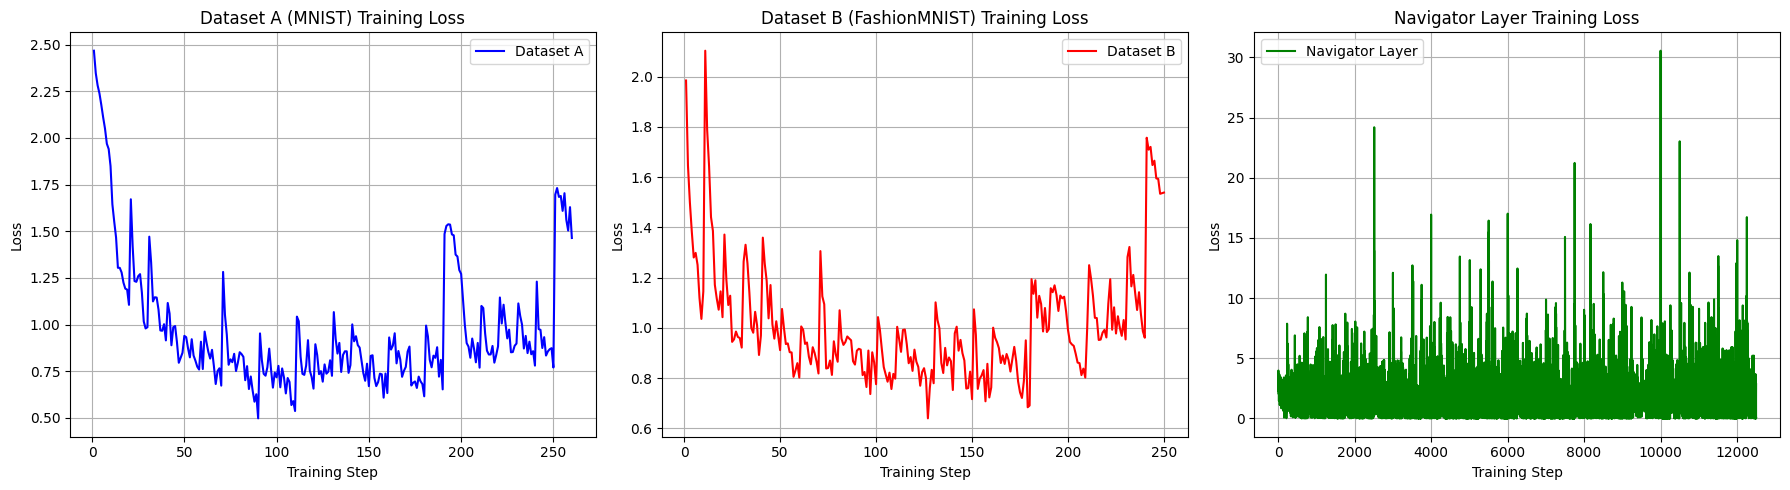

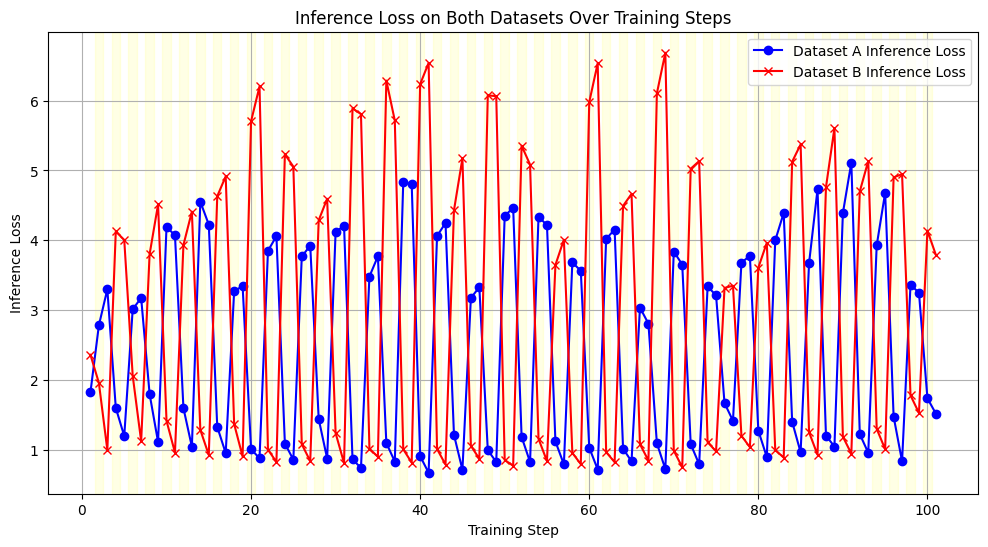

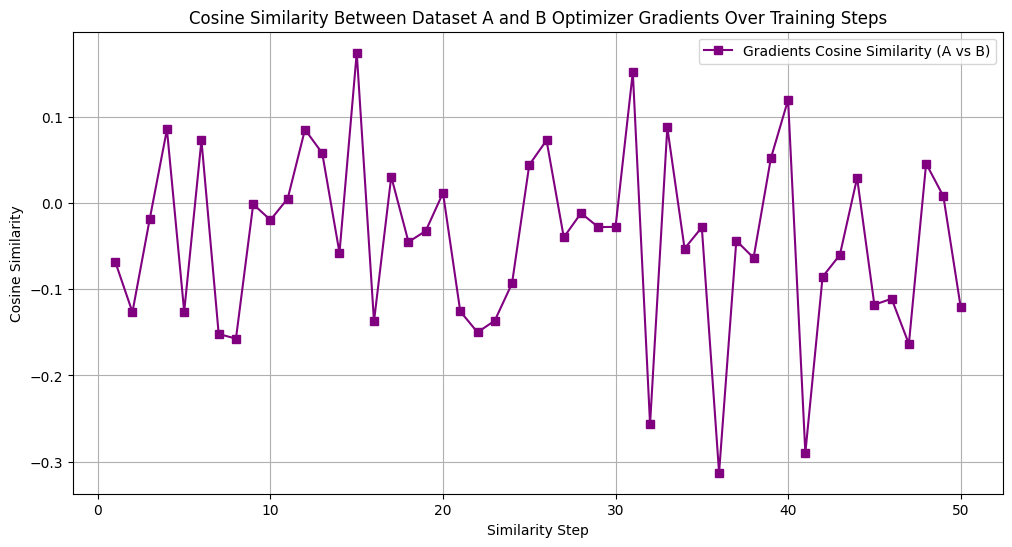

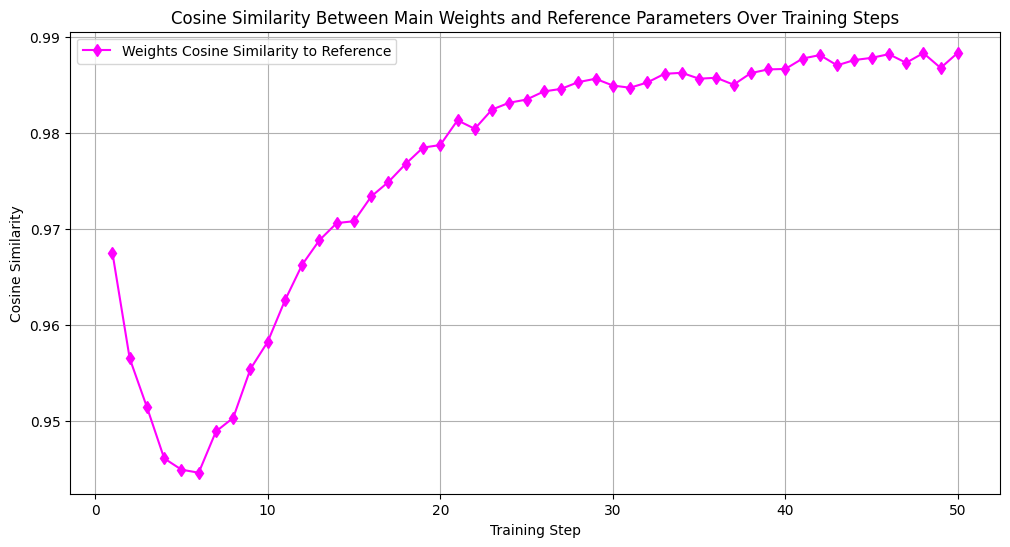

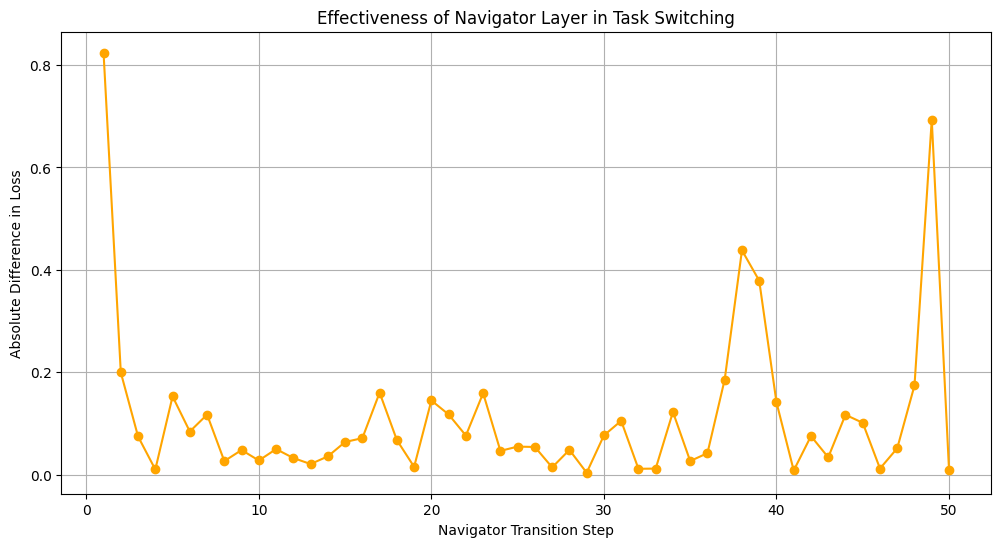

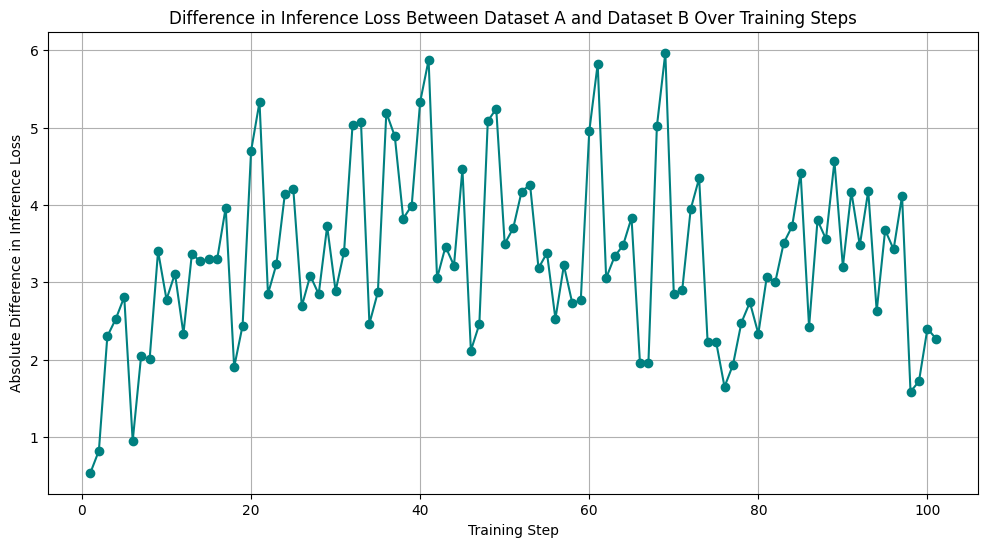

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import copy  # For deep copying reference parameters

# ===========================
# 1. Setup and Configuration
# ===========================

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration Parameters
batch_size = 512
subset_size = 5000  # Number of examples to use from each dataset for faster experiments
save_dir = "./saved_states"  # Directory to save the model and optimizer states
os.makedirs(save_dir, exist_ok=True)

# Hyperparameters for experiments
learning_rate_adam = 0.001  # Learning rate for ADAM optimizers
learning_rate_sgd = 0.001     # Learning rate for SGD optimizer (no longer used)
num_epochs_initial = 1        # Number of epochs for initial training on Dataset A
num_iterations = 50           # Number of times to repeat the training loop

# ===========================
# 1.a. Configurable Parameters
# ===========================

# Configuration for Random Layers
num_random_layers = 1       # Number of randomized layers to add
random_layer_size = 128     # Size (number of neurons) of each randomized layer

# Configuration for Navigator Layers
num_navigator_layers = 3    # Number of navigator layers to add

# Flag to re-randomize the random layers during task switching
re_randomize = True         # Set to True to re-randomize, False to keep them fixed

# Cosine Similarity Regularization Parameters
similarity_weight = 0.05   # Weight for the cosine similarity loss
ema_momentum = 0.9          # Momentum for updating reference parameters

# ===========================
# 2. Model Definition
# ===========================

class SimpleNet(nn.Module):
    """
    A simple neural network with configurable navigator layers and randomized layers.
    """
    def __init__(self, num_navigator_layers=1, num_random_layers=0, random_layer_size=128):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Add configurable navigator layers
        self.navigator_layers = nn.ModuleList()
        for _ in range(num_navigator_layers):
            nav_layer = nn.Linear(128, 128)
            self.navigator_layers.append(nav_layer)
            self.navigator_layers.append(nn.ReLU())
        
        # Add configurable random layers
        self.random_layers = nn.ModuleList()
        for _ in range(num_random_layers):
            rand_layer = nn.Linear(random_layer_size, random_layer_size)
            # Initialize with random weights and biases
            nn.init.normal_(rand_layer.weight)
            nn.init.normal_(rand_layer.bias)
            # Freeze the random layers
            for param in rand_layer.parameters():
                param.requires_grad = False
            self.random_layers.append(rand_layer)
            self.random_layers.append(nn.ReLU())
        
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        
        # Pass through navigator layers
        for layer in self.navigator_layers:
            x = layer(x)
        
        # Pass through random layers if any
        for layer in self.random_layers:
            x = layer(x)
        
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ===========================
# 3. Helper Functions
# ===========================

def load_subset_data(transform, dataset, subset_size=100):
    """
    Loads a subset of the specified dataset.
    """
    if dataset == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset == 'FashionMNIST':
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Unknown dataset {dataset}")
    
    train_subset = torch.utils.data.Subset(train_dataset, np.arange(subset_size))
    test_subset = torch.utils.data.Subset(test_dataset, np.arange(max(100, subset_size // 10)))  # Smaller test set
    
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def get_random_subset(dataset, fraction):
    """
    Returns a random subset of the dataset corresponding to the given fraction.
    """
    subset_size = int(len(dataset) * fraction)
    indices = np.random.choice(len(dataset), size=subset_size, replace=False)
    subset = torch.utils.data.Subset(dataset, indices)
    return subset

def get_flattened_gradients(params_to_include):
    """
    Extracts and flattens all gradients from the specified parameters into a single vector.
    """
    grads = []
    for param in params_to_include:
        if param.grad is not None:
            grads.append(param.grad.view(-1))
    if len(grads) == 0:
        return torch.zeros(1).to(device)
    return torch.cat(grads)

def compute_cosine_similarity(model, reference_parameters):
    """
    Computes the cosine similarity between the model's main parameters and the reference parameters.
    """
    # Extract main parameters (exclude navigators and random layers)
    current_params = [param.view(-1) for name, param in model.named_parameters() if 'navigator_layers' not in name and 'random_layers' not in name]
    ref_params = [ref.view(-1) for ref in reference_parameters]
    
    # Concatenate all parameters into single vectors
    current_vector = torch.cat(current_params)
    ref_vector = torch.cat(ref_params)
    
    # Compute cosine similarity
    cos_sim = F.cosine_similarity(current_vector, ref_vector, dim=0)
    return cos_sim.item()

def train_model(model, train_loader, optimizer, criterion, num_epochs, device, collect_gradients=False, params_to_include=None, reference_parameters=None, similarity_weight=0.0):
    """
    Trains the model and records training loss per epoch and per step.
    Optionally collects and returns the flattened gradient vector.
    Optionally includes a cosine similarity loss to align parameters with reference_parameters.
    Returns a tuple of (epoch_losses, step_losses, gradient_vector or None).
    """
    model.train()
    epoch_losses = []
    step_losses = []
    gradient_vector = None
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # If reference_parameters and similarity_weight are provided, compute cosine similarity loss
            if reference_parameters is not None:
                cos_sim = compute_cosine_similarity(model, reference_parameters)
                similarity_loss = similarity_weight * (1 - cos_sim)  # We want to maximize cos_sim
                loss = loss + similarity_loss
            
            loss.backward()
            
            if collect_gradients and params_to_include is not None:
                gradient_vector = get_flattened_gradients(params_to_include).detach().clone()
            
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            step_losses.append(loss.item())
        
        epoch_loss /= len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
    return epoch_losses, step_losses, gradient_vector

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluates the model on the test set and records test loss and accuracy.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    return test_loss, accuracy

def reinitialize_random_layers(model):
    """
    Reinitializes the weights and biases of the randomized layers.
    """
    for layer in model.random_layers:
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight)
            nn.init.normal_(layer.bias)

# ===========================
# 4. Main Execution Loop
# ===========================

def main():
    # Define the transforms for the datasets
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load Dataset A (MNIST) and Dataset B (FashionMNIST)
    train_loader_A, test_loader_A = load_subset_data(transform, 'MNIST', subset_size=subset_size)
    train_loader_B, test_loader_B = load_subset_data(transform, 'FashionMNIST', subset_size=subset_size)
    
    # Initialize model with the configured number of navigator and random layers
    model = SimpleNet(num_navigator_layers=num_navigator_layers, num_random_layers=num_random_layers, random_layer_size=random_layer_size).to(device)
    
    # Define the criterion
    criterion = nn.CrossEntropyLoss()
    
    # Collect parameters
    # Exclude random layers from trainable parameters
    params_main = [param for name, param in model.named_parameters() if 'navigator_layers' not in name and 'random_layers' not in name]
    params_navigator = [param for name, param in model.named_parameters() if 'navigator_layers' in name]
    
    # ===========================
    # 4.a. Define Optimizers
    # ===========================
    
    # Combine main parameters and navigator layers into a single optimizer per dataset
    # If you want different learning rates for navigators, use parameter groups
    optimizer_A = optim.Adam([
        {'params': params_main},
        {'params': params_navigator, 'lr': learning_rate_adam}  # You can set a different lr if desired
    ], lr=learning_rate_adam)
    
    optimizer_B = optim.Adam([
        {'params': params_main},
        {'params': params_navigator, 'lr': learning_rate_adam}  # You can set a different lr if desired
    ], lr=learning_rate_adam)
    
    # Remove the separate optimizer for navigator layers
    # optimizer_navigator = optim.SGD(params_navigator, lr=learning_rate_sgd)  # Removed
    
    # Initialize lists to store losses and cosine similarities
    individual_losses_A = []
    individual_losses_B = []
    individual_losses_navigator = []
    inference_losses_A = []
    inference_losses_B = []
    grad_cosine_similarities = []  # Renamed for clarity
    weight_cosine_similarities = []  # New list for weight cosine similarity
    training_steps = []
    training_phases = []
    
    step_counter = 1  # To index training steps for plotting
    last_grad_A = None
    last_grad_B = None
    
    # Initialize reference parameters as a deep copy of the current main parameters
    reference_parameters = [param.detach().clone() for param in params_main]
    
    # Step 2: Freeze the navigator layers and train on Dataset A
    for param in params_navigator:
        param.requires_grad = False
    # Training on Dataset A
    epoch_loss_A, step_loss_A, grad_A = train_model(
        model, 
        train_loader_A, 
        optimizer_A, 
        criterion, 
        num_epochs_initial, 
        device, 
        collect_gradients=True, 
        params_to_include=params_main,
        reference_parameters=None,  # No similarity loss for initial training
        similarity_weight=0.0
    )
    
    # Store the individual training loss for Dataset A
    individual_losses_A.extend(step_loss_A)
    
    # Store the last gradient from Dataset A
    last_grad_A = grad_A
    
    # Record inference loss after initial training
    if last_grad_A is not None:
        test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
        test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
        inference_losses_A.append(test_loss_A)
        inference_losses_B.append(test_loss_B)
        training_steps.append(step_counter)
        training_phases.append('Dataset A')
        step_counter += 1
    
    # Update reference parameters after initial training
    for ref, param in zip(reference_parameters, params_main):
        ref.data = ema_momentum * ref.data + (1 - ema_momentum) * param.data
    
    # Repeat the custom training loop
    for iteration in range(num_iterations):
        if iteration % 2 == 0:
            # Step 3: Freeze all layers except the navigator layers
            for param in params_main:
                param.requires_grad = False
            for param in params_navigator:
                param.requires_grad = True

            # Optional: Re-randomize the random layers if the flag is set
            if re_randomize:
                reinitialize_random_layers(model)
            
            # Step 4: Train on a random 5% of Dataset B (Navigator Layer)
            subset_B = get_random_subset(train_loader_B.dataset, fraction=0.05)
            loader_B_subset = torch.utils.data.DataLoader(subset_B, batch_size=1, shuffle=True)
            epoch_loss_nav, step_loss_nav, _ = train_model(
                model, 
                loader_B_subset, 
                optimizer_B,  # Use optimizer_B instead of optimizer_navigator
                criterion, 
                1, 
                device, 
                collect_gradients=False,
                reference_parameters=None,  # No similarity loss during navigator training
                similarity_weight=0.0
            )
            
            # Store the individual training loss for Navigator
            individual_losses_navigator.extend(step_loss_nav)
            
            # Record inference loss after navigator training
            test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
            test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
            inference_losses_A.append(test_loss_A)
            inference_losses_B.append(test_loss_B)
            training_steps.append(step_counter)
            training_phases.append('Navigator')
            step_counter += 1
            
            # Step 5: Unfreeze all layers except the navigator layers
            for param in params_main:
                param.requires_grad = True
            for param in params_navigator:
                param.requires_grad = False
            
            # Step 6: Train a full epoch on Dataset B with Cosine Similarity Regularization
            epoch_loss_B, step_loss_B, grad_B = train_model(
                model, 
                train_loader_B, 
                optimizer_B, 
                criterion, 
                1, 
                device, 
                collect_gradients=True, 
                params_to_include=params_main,
                reference_parameters=reference_parameters,  # Provide reference parameters
                similarity_weight=similarity_weight
            )
            
            # Store the individual training loss for Dataset B
            individual_losses_B.extend(step_loss_B)
            
            # Store the last gradient from Dataset B
            last_grad_B = grad_B
            
            if last_grad_A is not None and last_grad_B is not None:
                # Compute cosine similarity between last_grad_A and last_grad_B
                cos_sim_grad = F.cosine_similarity(last_grad_A, last_grad_B, dim=0).item()
                grad_cosine_similarities.append(cos_sim_grad)
            
            # Record inference loss after Dataset B training
            if last_grad_A is not None and last_grad_B is not None:
                test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
                test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
                inference_losses_A.append(test_loss_A)
                inference_losses_B.append(test_loss_B)
                training_steps.append(step_counter)
                training_phases.append('Dataset B')
                step_counter += 1
            
            # Update reference parameters using EMA
            for ref, param in zip(reference_parameters, params_main):
                ref.data = ema_momentum * ref.data + (1 - ema_momentum) * param.data
            
            # Compute and store weight cosine similarity
            cos_sim_weight = compute_cosine_similarity(model, reference_parameters)
            weight_cosine_similarities.append(cos_sim_weight)
        else:
            # Step 3: Freeze all layers except the navigator layers
            for param in params_main:
                param.requires_grad = False
            for param in params_navigator:
                param.requires_grad = True

            # Optional: Re-randomize the random layers if the flag is set
            if re_randomize:
                reinitialize_random_layers(model)

            # Step 4: Train on a random 5% of Dataset A (Navigator Layer)
            subset_A = get_random_subset(train_loader_A.dataset, fraction=0.05)
            loader_A_subset = torch.utils.data.DataLoader(subset_A, batch_size=1, shuffle=True)
            epoch_loss_nav, step_loss_nav, _ = train_model(
                model, 
                loader_A_subset, 
                optimizer_A,  # Use optimizer_A instead of optimizer_navigator
                criterion, 
                1, 
                device, 
                collect_gradients=False,
                reference_parameters=None,  # No similarity loss during navigator training
                similarity_weight=0.0
            )
            
            # Store the individual training loss for Navigator
            individual_losses_navigator.extend(step_loss_nav)
            
            # Record inference loss after navigator training
            test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
            test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
            inference_losses_A.append(test_loss_A)
            inference_losses_B.append(test_loss_B)
            training_steps.append(step_counter)
            training_phases.append('Navigator')
            step_counter += 1
            
            # Step 5: Unfreeze all layers except the navigator layers
            for param in params_main:
                param.requires_grad = True
            for param in params_navigator:
                param.requires_grad = False
            
            # Step 6: Train a full epoch on Dataset A with Cosine Similarity Regularization
            epoch_loss_A, step_loss_A, grad_A = train_model(
                model, 
                train_loader_A, 
                optimizer_A, 
                criterion, 
                1, 
                device, 
                collect_gradients=True, 
                params_to_include=params_main,
                reference_parameters=reference_parameters,  # Provide reference parameters
                similarity_weight=similarity_weight
            )
            
            # Store the individual training loss for Dataset A
            individual_losses_A.extend(step_loss_A)
            
            # Store the last gradient from Dataset A
            last_grad_A = grad_A
            
            if last_grad_A is not None and last_grad_B is not None:
                # Compute cosine similarity between last_grad_A and last_grad_B
                cos_sim_grad = F.cosine_similarity(last_grad_A, last_grad_B, dim=0).item()
                grad_cosine_similarities.append(cos_sim_grad)
            
            # Record inference loss after Dataset A training
            if last_grad_A is not None and last_grad_B is not None:
                test_loss_A, _ = evaluate_model(model, test_loader_A, criterion, device)
                test_loss_B, _ = evaluate_model(model, test_loader_B, criterion, device)
                inference_losses_A.append(test_loss_A)
                inference_losses_B.append(test_loss_B)
                training_steps.append(step_counter)
                training_phases.append('Dataset A')
                step_counter += 1
            
            # Update reference parameters using EMA
            for ref, param in zip(reference_parameters, params_main):
                ref.data = ema_momentum * ref.data + (1 - ema_momentum) * param.data
            
            # Compute and store weight cosine similarity
            cos_sim_weight = compute_cosine_similarity(model, reference_parameters)
            weight_cosine_similarities.append(cos_sim_weight)
    
        # ===========================
        # 5. Evaluation and Visualization
        # ===========================
        
        # After training loop
        test_loss_A_final, test_accuracy_A = evaluate_model(model, test_loader_A, criterion, device)
        test_loss_B_final, test_accuracy_B = evaluate_model(model, test_loader_B, criterion, device)
        
        print(f"\nFinal Test Accuracy on Dataset A (MNIST): {test_accuracy_A:.2f}%")
        print(f"Final Test Accuracy on Dataset B (FashionMNIST): {test_accuracy_B:.2f}%")
    
    # ===========================
    # 6. Visualization (at the end of all iterations)
    # ===========================

    # 1. Three Individual Loss Plots (1x3 Subplot)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Dataset A Training Loss
    axes[0].plot(range(1, len(individual_losses_A) + 1), individual_losses_A, color='blue', label='Dataset A')
    axes[0].set_title('Dataset A (MNIST) Training Loss')
    axes[0].set_xlabel('Training Step')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()
    
    # Dataset B Training Loss
    axes[1].plot(range(1, len(individual_losses_B) + 1), individual_losses_B, color='red', label='Dataset B')
    axes[1].set_title('Dataset B (FashionMNIST) Training Loss')
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    axes[1].legend()
    
    # Navigator Layer Training Loss
    axes[2].plot(range(1, len(individual_losses_navigator) + 1), individual_losses_navigator, color='green', label='Navigator Layer')
    axes[2].set_title('Navigator Layer Training Loss')
    axes[2].set_xlabel('Training Step')
    axes[2].set_ylabel('Loss')
    axes[2].grid(True)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 2. Cumulative Inference Loss Plot
    plt.figure(figsize=(12, 6))
    plt.plot(training_steps, inference_losses_A, label='Dataset A Inference Loss', marker='o', color='blue')
    plt.plot(training_steps, inference_losses_B, label='Dataset B Inference Loss', marker='x', color='red')
    
    # Highlight Navigator Training Steps
    for idx, phase in enumerate(training_phases):
        if phase == 'Navigator':
            plt.axvspan(training_steps[idx]-0.5, training_steps[idx]+0.5, color='yellow', alpha=0.1)
    
    plt.xlabel('Training Step')
    plt.ylabel('Inference Loss')
    plt.title('Inference Loss on Both Datasets Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 3. Gradients Cosine Similarity Plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(grad_cosine_similarities) + 1), grad_cosine_similarities, label='Gradients Cosine Similarity (A vs B)', marker='s', color='purple')
    plt.xlabel('Similarity Step')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Between Dataset A and B Optimizer Gradients Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. Weight Cosine Similarity Plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(weight_cosine_similarities) + 1), weight_cosine_similarities, label='Weights Cosine Similarity to Reference', marker='d', color='magenta')
    plt.xlabel('Training Step')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Between Main Weights and Reference Parameters Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 5. Plotting the Difference Between Navigator Step and Following Step
    diff_navigator_effectiveness = []
    
    for idx in range(1, len(training_phases) - 1):
        if training_phases[idx] == 'Navigator':
            if training_phases[idx - 1] == 'Dataset A' and training_phases[idx + 1] == 'Dataset B':
                # Navigator transition from A -> B
                diff_value = abs(inference_losses_B[idx + 1] - inference_losses_A[idx - 1])
            elif training_phases[idx - 1] == 'Dataset B' and training_phases[idx + 1] == 'Dataset A':
                # Navigator transition from B -> A
                diff_value = abs(inference_losses_A[idx + 1] - inference_losses_B[idx - 1])
            else:
                continue
            diff_navigator_effectiveness.append(diff_value)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(diff_navigator_effectiveness) + 1), diff_navigator_effectiveness, marker='o', color='orange')
    plt.xlabel('Navigator Transition Step')
    plt.ylabel('Absolute Difference in Loss')
    plt.title('Effectiveness of Navigator Layer in Task Switching')
    plt.grid(True)
    plt.show()

    # 6. Plotting the Difference Between Dataset A and Dataset B Inference Losses at Each Step
    diff_between_datasets = []
    
    for idx in range(len(inference_losses_A)):
        difference_value = abs(inference_losses_A[idx] - inference_losses_B[idx])
        diff_between_datasets.append(difference_value)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(diff_between_datasets) + 1), diff_between_datasets, marker='o', color='teal')
    plt.xlabel('Training Step')
    plt.ylabel('Absolute Difference in Inference Loss')
    plt.title('Difference in Inference Loss Between Dataset A and Dataset B Over Training Steps')
    plt.grid(True)
    plt.show()


    
if __name__ == "__main__":
    main()


Using device: cuda

Final Test Accuracy on Dataset A (MNIST): 46.00%
Final Test Accuracy on Dataset B (FashionMNIST): 57.00%


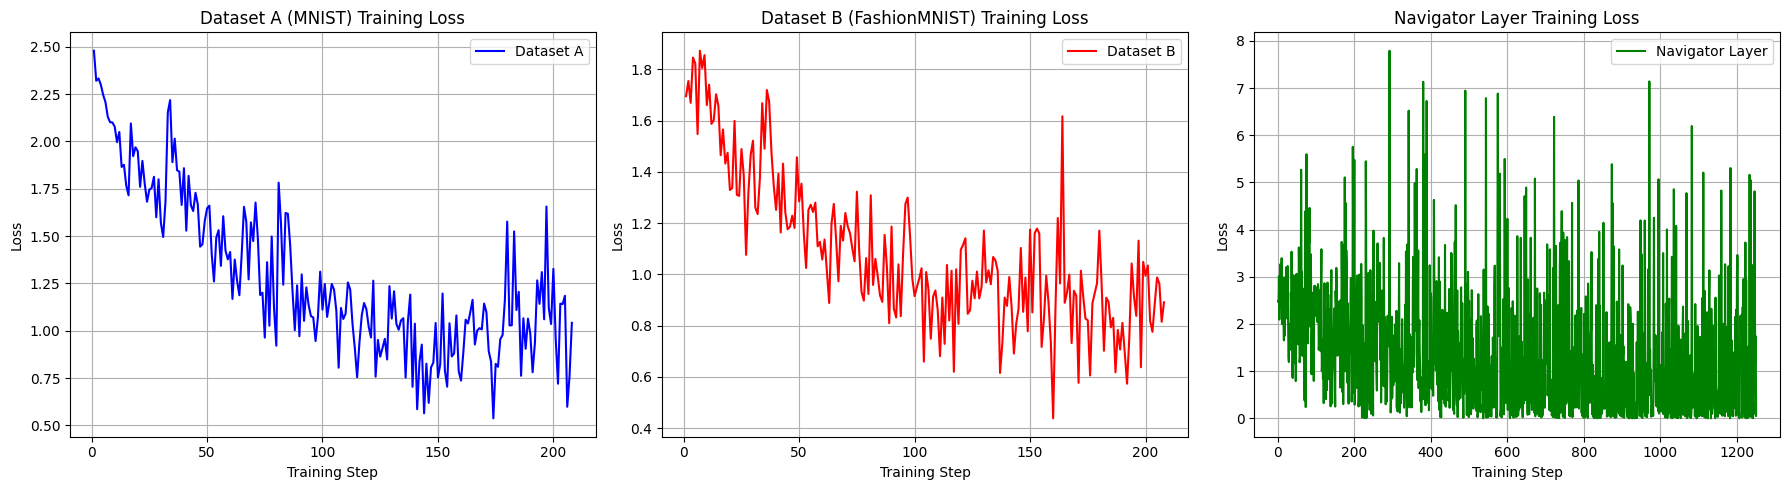

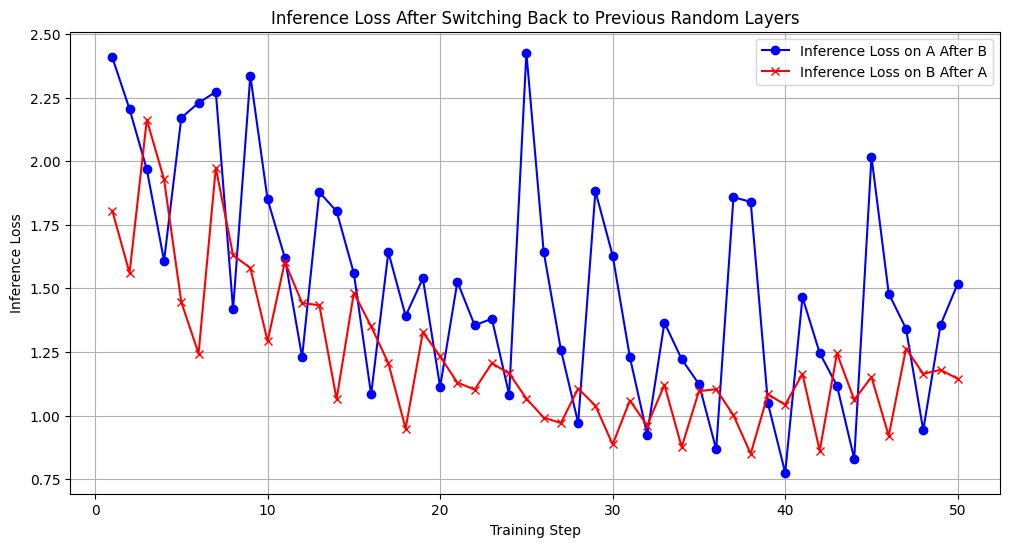

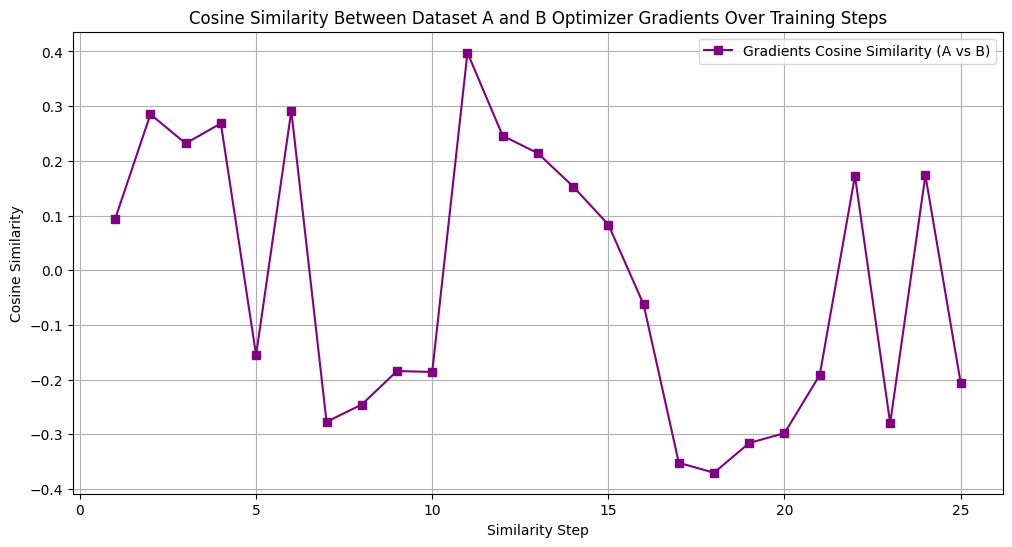

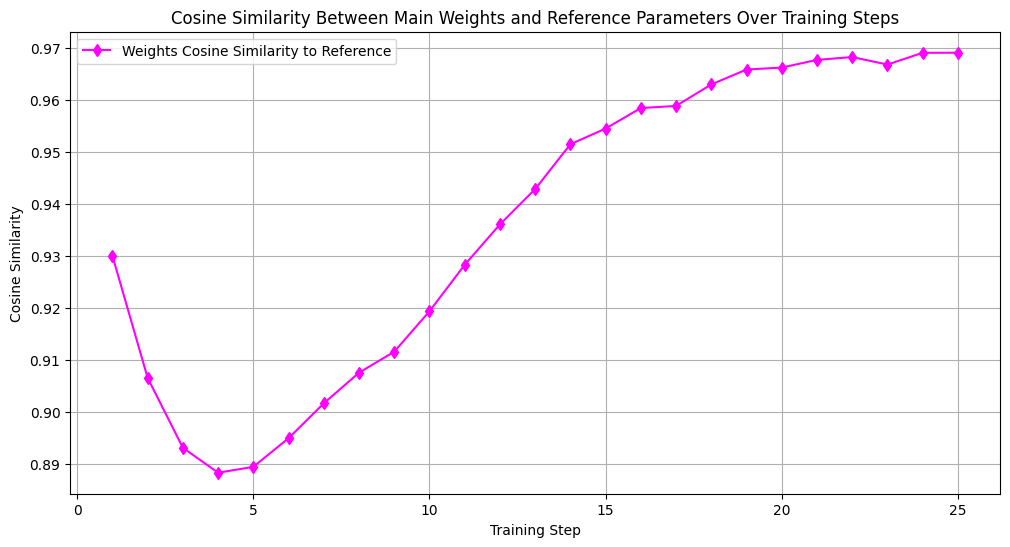

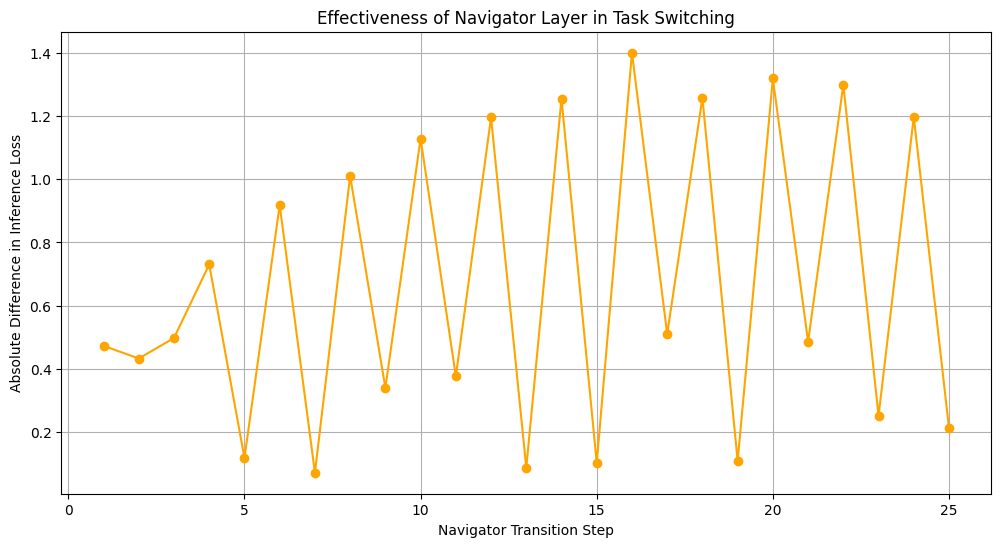

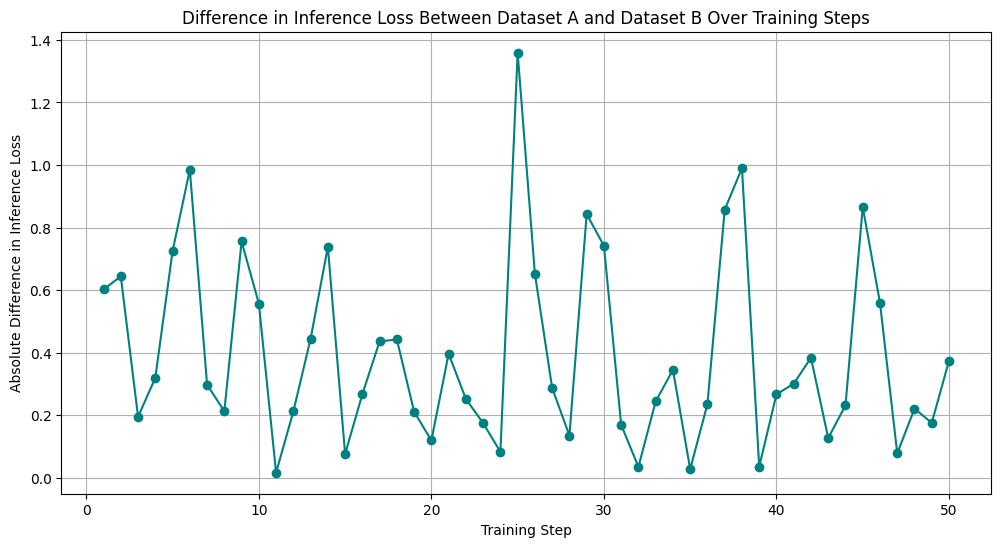

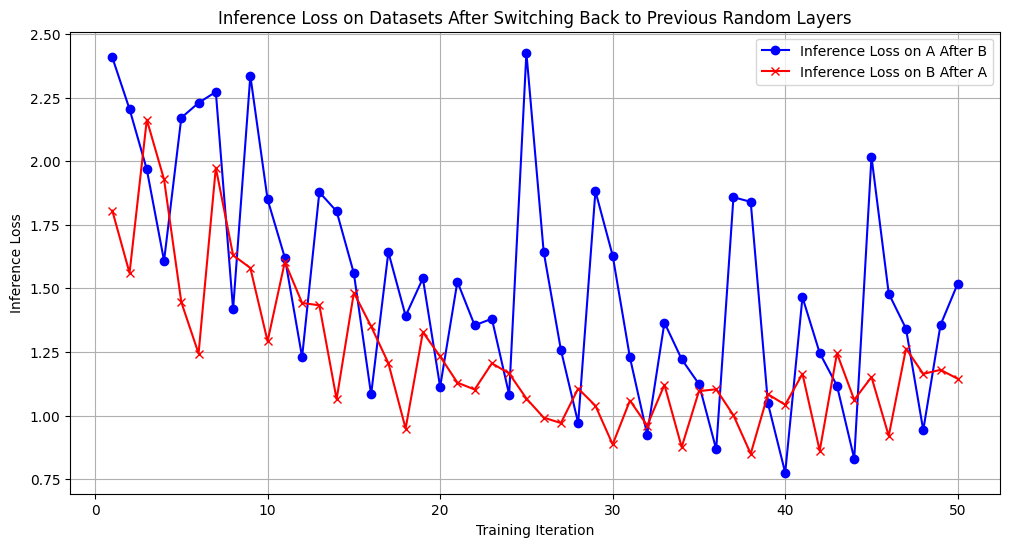

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import copy  # For deep copying reference parameters

# ===========================
# 1. Setup and Configuration
# ===========================

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration Parameters
batch_size = 64
subset_size = 1000  # Number of examples to use from each dataset for faster experiments
save_dir = "./saved_states"  # Directory to save the model and optimizer states
os.makedirs(save_dir, exist_ok=True)

# Hyperparameters for experiments
learning_rate_adam = 0.001  # Learning rate for ADAM optimizers
learning_rate_sgd = 0.001     # Learning rate for SGD optimizer (no longer used)
num_epochs_initial = 1        # Number of epochs for initial training on Dataset A
num_iterations = 25           # Number of times to repeat the training loop

# ===========================
# 1.a. Configurable Parameters
# ===========================

# Configuration for Random Layers
num_random_layers = 1       # Number of randomized layers to add
random_layer_size = 128     # Size (number of neurons) of each randomized layer

# Configuration for Navigator Layers
num_navigator_layers = 3    # Number of navigator layers to add

# Flag to re-randomize the random layers during task switching
re_randomize = False         # Set to True to re-randomize, False to keep them fixed

# Cosine Similarity Regularization Parameters
similarity_weight = 0.05   # Weight for the cosine similarity loss
ema_momentum = 0.9          # Momentum for updating reference parameters

# ===========================
# 2. Model Definition
# ===========================

class SimpleNet(nn.Module):
    """
    A simple neural network with configurable navigator layers and randomized layers.
    """
    def __init__(self, num_navigator_layers=1, num_random_layers=0, random_layer_size=128):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        
        # Add configurable navigator layers
        self.navigator_layers = nn.ModuleList()
        for _ in range(num_navigator_layers):
            nav_layer = nn.Linear(128, 128)
            self.navigator_layers.append(nav_layer)
            self.navigator_layers.append(nn.ReLU())
        
        # Add configurable random layers
        self.random_layers = nn.ModuleList()
        for _ in range(num_random_layers):
            rand_layer = nn.Linear(random_layer_size, random_layer_size)
            # Initialize with random weights and biases
            nn.init.normal_(rand_layer.weight)
            nn.init.normal_(rand_layer.bias)
            # Freeze the random layers
            for param in rand_layer.parameters():
                param.requires_grad = False
            self.random_layers.append(rand_layer)
            self.random_layers.append(nn.ReLU())
        
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = x.view(-1, 28 * 28)  # Flatten the input
        x = self.fc1(x)
        
        # Pass through navigator layers
        for layer in self.navigator_layers:
            x = layer(x)
        
        # Pass through random layers if any
        for layer in self.random_layers:
            x = layer(x)
        
        x = self.relu(x)
        x = self.fc2(x)
        return x

# ===========================
# 3. Helper Functions
# ===========================

def load_subset_data(transform, dataset, subset_size=100):
    """
    Loads a subset of the specified dataset.
    """
    if dataset == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    elif dataset == 'FashionMNIST':
        train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
    else:
        raise ValueError(f"Unknown dataset {dataset}")
    
    train_subset = torch.utils.data.Subset(train_dataset, np.arange(subset_size))
    test_subset = torch.utils.data.Subset(test_dataset, np.arange(max(100, subset_size // 10)))  # Smaller test set
    
    train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def get_random_subset(dataset, fraction):
    """
    Returns a random subset of the dataset corresponding to the given fraction.
    """
    subset_size = int(len(dataset) * fraction)
    indices = np.random.choice(len(dataset), size=subset_size, replace=False)
    subset = torch.utils.data.Subset(dataset, indices)
    return subset

def get_flattened_gradients(params_to_include):
    """
    Extracts and flattens all gradients from the specified parameters into a single vector.
    """
    grads = []
    for param in params_to_include:
        if param.grad is not None:
            grads.append(param.grad.view(-1))
    if len(grads) == 0:
        return torch.zeros(1).to(device)
    return torch.cat(grads)

def compute_cosine_similarity(model, reference_parameters):
    """
    Computes the cosine similarity between the model's main parameters and the reference parameters.
    """
    # Extract main parameters (exclude navigators and random layers)
    current_params = [param.view(-1) for name, param in model.named_parameters() if 'navigator_layers' not in name and 'random_layers' not in name]
    ref_params = [ref.view(-1) for ref in reference_parameters]
    
    # Concatenate all parameters into single vectors
    current_vector = torch.cat(current_params)
    ref_vector = torch.cat(ref_params)
    
    # Compute cosine similarity
    cos_sim = F.cosine_similarity(current_vector, ref_vector, dim=0)
    return cos_sim.item()

def train_model(model, train_loader, optimizer, criterion, num_epochs, device, collect_gradients=False, params_to_include=None, reference_parameters=None, similarity_weight=0.0):
    """
    Trains the model and records training loss per epoch and per step.
    Optionally collects and returns the flattened gradient vector.
    Optionally includes a cosine similarity loss to align parameters with reference_parameters.
    Returns a tuple of (epoch_losses, step_losses, gradient_vector or None).
    """
    model.train()
    epoch_losses = []
    step_losses = []
    gradient_vector = None
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # If reference_parameters and similarity_weight are provided, compute cosine similarity loss
            if reference_parameters is not None:
                cos_sim = compute_cosine_similarity(model, reference_parameters)
                similarity_loss = similarity_weight * (1 - cos_sim)  # We want to maximize cos_sim
                loss = loss + similarity_loss
            
            loss.backward()
            
            if collect_gradients and params_to_include is not None:
                gradient_vector = get_flattened_gradients(params_to_include).detach().clone()
            
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            step_losses.append(loss.item())
        
        epoch_loss /= len(train_loader.dataset)
        epoch_losses.append(epoch_loss)
    return epoch_losses, step_losses, gradient_vector

def evaluate_model(model, test_loader, criterion, device):
    """
    Evaluates the model on the test set and records test loss and accuracy.
    """
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100 * correct / total
    return test_loss, accuracy

def reinitialize_random_layers(model):
    """
    Reinitializes the weights and biases of the randomized layers.
    """
    for layer in model.random_layers:
        if isinstance(layer, nn.Linear):
            nn.init.normal_(layer.weight)
            nn.init.normal_(layer.bias)

def save_random_layer_state(model, save_path):
    """
    Saves the state dictionary of the random layers.
    """
    random_layers_state = {}
    for idx, layer in enumerate(model.random_layers):
        random_layers_state[f'random_layer_{idx}'] = layer.state_dict()
    torch.save(random_layers_state, save_path)

def load_random_layer_state(model, load_path):
    """
    Loads the state dictionary of the random layers.
    """
    random_layers_state = torch.load(load_path, map_location=device)
    for idx, layer in enumerate(model.random_layers):
        layer.load_state_dict(random_layers_state[f'random_layer_{idx}'])

# ===========================
# 4. Main Execution Loop
# ===========================

def main():
    # Define the transforms for the datasets
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load Dataset A (MNIST) and Dataset B (FashionMNIST)
    train_loader_A, test_loader_A = load_subset_data(transform, 'MNIST', subset_size=subset_size)
    train_loader_B, test_loader_B = load_subset_data(transform, 'FashionMNIST', subset_size=subset_size)
    
    # Initialize model with the configured number of navigator and random layers
    model = SimpleNet(num_navigator_layers=num_navigator_layers, num_random_layers=num_random_layers, random_layer_size=random_layer_size).to(device)
    
    # Define the criterion
    criterion = nn.CrossEntropyLoss()
    
    # Collect parameters
    # Exclude random layers from trainable parameters
    params_main = [param for name, param in model.named_parameters() if 'navigator_layers' not in name and 'random_layers' not in name]
    params_navigator = [param for name, param in model.named_parameters() if 'navigator_layers' in name]
    
    # ===========================
    # 4.a. Define Optimizers
    # ===========================
    
    # Combine main parameters and navigator layers into a single optimizer per dataset
    # If you want different learning rates for navigators, use parameter groups
    optimizer_A = optim.Adam([
        {'params': params_main},
        {'params': params_navigator, 'lr': learning_rate_adam}  # You can set a different lr if desired
    ], lr=learning_rate_adam)
    
    optimizer_B = optim.Adam([
        {'params': params_main},
        {'params': params_navigator, 'lr': learning_rate_adam}  # You can set a different lr if desired
    ], lr=learning_rate_adam)
    
    # Initialize lists to store losses and cosine similarities
    individual_losses_A = []
    individual_losses_B = []
    individual_losses_navigator = []
    inference_losses_A_after_B = []  # Inference loss on A after training on B
    inference_losses_B_after_A = []  # Inference loss on B after training on A
    inference_losses_A_initial = []
    inference_losses_B_initial = []
    grad_cosine_similarities = []  # Renamed for clarity
    weight_cosine_similarities = []  # New list for weight cosine similarity
    training_steps = []
    training_phases = []
    
    step_counter = 1  # To index training steps for plotting
    
    # Initialize reference parameters as a deep copy of the current main parameters
    reference_parameters = [param.detach().clone() for param in params_main]
    
    # Dictionaries to store random layer states for Dataset A and B
    random_layers_A = {}
    random_layers_B = {}
    
    # ===========================
    # 4.b. Initial Training on Dataset A
    # ===========================
    
    # Step 1: Freeze the navigator layers and train on Dataset A
    for param in params_navigator:
        param.requires_grad = False
    # Training on Dataset A
    epoch_loss_A, step_loss_A, grad_A = train_model(
        model, 
        train_loader_A, 
        optimizer_A, 
        criterion, 
        num_epochs_initial, 
        device, 
        collect_gradients=True, 
        params_to_include=params_main,
        reference_parameters=None,  # No similarity loss for initial training
        similarity_weight=0.0
    )
    
    # Store the individual training loss for Dataset A
    individual_losses_A.extend(step_loss_A)
    
    # Store the last gradient from Dataset A
    last_grad_A = grad_A
    
    # Save the random layers state after training on Dataset A
    random_layers_A_path = os.path.join(save_dir, 'random_layers_A.pth')
    save_random_layer_state(model, random_layers_A_path)
    random_layers_A = copy.deepcopy(random_layers_A_path)
    
    # Record inference loss after initial training on A
    test_loss_A_initial, _ = evaluate_model(model, test_loader_A, criterion, device)
    test_loss_B_initial, _ = evaluate_model(model, test_loader_B, criterion, device)
    inference_losses_A_initial.append(test_loss_A_initial)
    inference_losses_B_initial.append(test_loss_B_initial)
    training_steps.append(step_counter)
    training_phases.append('Initial Training on A')
    step_counter += 1
    
    # Update reference parameters after initial training
    for ref, param in zip(reference_parameters, params_main):
        ref.data = ema_momentum * ref.data + (1 - ema_momentum) * param.data
    
    # ===========================
    # 4.c. Define Functions for Switching Layers
    # ===========================
    
    def switch_random_layers(model, target_path):
        """
        Switches the model's random layers to the ones saved at target_path.
        """
        load_random_layer_state(model, target_path)
    
    # ===========================
    # 4.d. Training Iterations
    # ===========================
    
    for iteration in range(num_iterations):
        if iteration % 2 == 0:
            # Even iterations: Train on Dataset B
            # Step 2: Switch to Dataset B's random layers (initialize if first time)
            if not os.path.exists(os.path.join(save_dir, 'random_layers_B.pth')):
                # If random_layers_B does not exist, initialize it
                if re_randomize:
                    reinitialize_random_layers(model)
                save_random_layer_state(model, os.path.join(save_dir, 'random_layers_B.pth'))
            else:
                switch_random_layers(model, os.path.join(save_dir, 'random_layers_B.pth'))
            
            # Step 3: Train on a random subset of Dataset B (Navigator Layer)
            subset_B = get_random_subset(train_loader_B.dataset, fraction=0.05)
            loader_B_subset = torch.utils.data.DataLoader(subset_B, batch_size=1, shuffle=True)
            epoch_loss_nav, step_loss_nav, _ = train_model(
                model, 
                loader_B_subset, 
                optimizer_B, 
                criterion, 
                1, 
                device, 
                collect_gradients=False,
                reference_parameters=None,  # No similarity loss during navigator training
                similarity_weight=0.0
            )
            
            # Store the individual training loss for Navigator
            individual_losses_navigator.extend(step_loss_nav)
            
            # Record inference loss after navigator training
            test_loss_A, test_acc_A = evaluate_model(model, test_loader_A, criterion, device)
            test_loss_B, test_acc_B = evaluate_model(model, test_loader_B, criterion, device)
            inference_losses_A_after_B.append(test_loss_A)
            inference_losses_B_after_A.append(test_loss_B)
            training_steps.append(step_counter)
            training_phases.append('Navigator Training on B')
            step_counter += 1
            
            # Step 4: Unfreeze all layers except the navigator layers
            for param in params_main:
                param.requires_grad = True
            for param in params_navigator:
                param.requires_grad = False
            
            # Step 5: Train a full epoch on Dataset B with Cosine Similarity Regularization
            epoch_loss_B, step_loss_B, grad_B = train_model(
                model, 
                train_loader_B, 
                optimizer_B, 
                criterion, 
                1, 
                device, 
                collect_gradients=True, 
                params_to_include=params_main,
                reference_parameters=reference_parameters,  # Provide reference parameters
                similarity_weight=similarity_weight
            )
            
            # Store the individual training loss for Dataset B
            individual_losses_B.extend(step_loss_B)
            
            # Store the last gradient from Dataset B
            last_grad_B = grad_B
            
            if last_grad_A is not None and last_grad_B is not None:
                # Compute cosine similarity between last_grad_A and last_grad_B
                cos_sim_grad = F.cosine_similarity(last_grad_A, last_grad_B, dim=0).item()
                grad_cosine_similarities.append(cos_sim_grad)
            
            # Record inference loss after Dataset B training
            test_loss_A, test_acc_A = evaluate_model(model, test_loader_A, criterion, device)
            test_loss_B, test_acc_B = evaluate_model(model, test_loader_B, criterion, device)
            inference_losses_A_after_B.append(test_loss_A)
            inference_losses_B_after_A.append(test_loss_B)
            training_steps.append(step_counter)
            training_phases.append('Dataset B Training')
            step_counter += 1
            
            # Save the random layers state after training on Dataset B
            save_random_layer_state(model, os.path.join(save_dir, 'random_layers_B.pth'))
            
            # Update reference parameters using EMA
            for ref, param in zip(reference_parameters, params_main):
                ref.data = ema_momentum * ref.data + (1 - ema_momentum) * param.data
            
            # Compute and store weight cosine similarity
            cos_sim_weight = compute_cosine_similarity(model, reference_parameters)
            weight_cosine_similarities.append(cos_sim_weight)
        else:
            # Odd iterations: Train on Dataset A
            # Step 2: Switch to Dataset A's random layers
            switch_random_layers(model, random_layers_A_path)
            
            # Step 3: Train on a random subset of Dataset A (Navigator Layer)
            subset_A = get_random_subset(train_loader_A.dataset, fraction=0.05)
            loader_A_subset = torch.utils.data.DataLoader(subset_A, batch_size=1, shuffle=True)
            epoch_loss_nav, step_loss_nav, _ = train_model(
                model, 
                loader_A_subset, 
                optimizer_A, 
                criterion, 
                1, 
                device, 
                collect_gradients=False,
                reference_parameters=None,  # No similarity loss during navigator training
                similarity_weight=0.0
            )
            
            # Store the individual training loss for Navigator
            individual_losses_navigator.extend(step_loss_nav)
            
            # Record inference loss after navigator training
            test_loss_A, test_acc_A = evaluate_model(model, test_loader_A, criterion, device)
            test_loss_B, test_acc_B = evaluate_model(model, test_loader_B, criterion, device)
            inference_losses_A_after_B.append(test_loss_A)
            inference_losses_B_after_A.append(test_loss_B)
            training_steps.append(step_counter)
            training_phases.append('Navigator Training on A')
            step_counter += 1
            
            # Step 4: Unfreeze all layers except the navigator layers
            for param in params_main:
                param.requires_grad = True
            for param in params_navigator:
                param.requires_grad = False
            
            # Step 5: Train a full epoch on Dataset A with Cosine Similarity Regularization
            epoch_loss_A, step_loss_A, grad_A = train_model(
                model, 
                train_loader_A, 
                optimizer_A, 
                criterion, 
                1, 
                device, 
                collect_gradients=True, 
                params_to_include=params_main,
                reference_parameters=reference_parameters,  # Provide reference parameters
                similarity_weight=similarity_weight
            )
            
            # Store the individual training loss for Dataset A
            individual_losses_A.extend(step_loss_A)
            
            # Store the last gradient from Dataset A
            last_grad_A = grad_A
            
            if last_grad_A is not None and last_grad_B is not None:
                # Compute cosine similarity between last_grad_A and last_grad_B
                cos_sim_grad = F.cosine_similarity(last_grad_A, last_grad_B, dim=0).item()
                grad_cosine_similarities.append(cos_sim_grad)
            
            # Record inference loss after Dataset A training
            test_loss_A, test_acc_A = evaluate_model(model, test_loader_A, criterion, device)
            test_loss_B, test_acc_B = evaluate_model(model, test_loader_B, criterion, device)
            inference_losses_A_after_B.append(test_loss_A)
            inference_losses_B_after_A.append(test_loss_B)
            training_steps.append(step_counter)
            training_phases.append('Dataset A Training')
            step_counter += 1
            
            # Save the random layers state after training on Dataset A
            save_random_layer_state(model, random_layers_A_path)
            
            # Update reference parameters using EMA
            for ref, param in zip(reference_parameters, params_main):
                ref.data = ema_momentum * ref.data + (1 - ema_momentum) * param.data
            
            # Compute and store weight cosine similarity
            cos_sim_weight = compute_cosine_similarity(model, reference_parameters)
            weight_cosine_similarities.append(cos_sim_weight)
    
    # ===========================
    # 5. Evaluation and Visualization
    # ===========================
    
    # Final Evaluation
    test_loss_A_final, test_accuracy_A = evaluate_model(model, test_loader_A, criterion, device)
    test_loss_B_final, test_accuracy_B = evaluate_model(model, test_loader_B, criterion, device)
    
    print(f"\nFinal Test Accuracy on Dataset A (MNIST): {test_accuracy_A:.2f}%")
    print(f"Final Test Accuracy on Dataset B (FashionMNIST): {test_accuracy_B:.2f}%")
    
    # ===========================
    # 6. Visualization (at the end of all iterations)
    # ===========================

    # 1. Three Individual Loss Plots (1x3 Subplot)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Dataset A Training Loss
    axes[0].plot(range(1, len(individual_losses_A) + 1), individual_losses_A, color='blue', label='Dataset A')
    axes[0].set_title('Dataset A (MNIST) Training Loss')
    axes[0].set_xlabel('Training Step')
    axes[0].set_ylabel('Loss')
    axes[0].grid(True)
    axes[0].legend()
    
    # Dataset B Training Loss
    axes[1].plot(range(1, len(individual_losses_B) + 1), individual_losses_B, color='red', label='Dataset B')
    axes[1].set_title('Dataset B (FashionMNIST) Training Loss')
    axes[1].set_xlabel('Training Step')
    axes[1].set_ylabel('Loss')
    axes[1].grid(True)
    axes[1].legend()
    
    # Navigator Layer Training Loss
    axes[2].plot(range(1, len(individual_losses_navigator) + 1), individual_losses_navigator, color='green', label='Navigator Layer')
    axes[2].set_title('Navigator Layer Training Loss')
    axes[2].set_xlabel('Training Step')
    axes[2].set_ylabel('Loss')
    axes[2].grid(True)
    axes[2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 2. Cumulative Inference Loss Plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(inference_losses_A_after_B) + 1), inference_losses_A_after_B, label='Inference Loss on A After B', marker='o', color='blue')
    plt.plot(range(1, len(inference_losses_B_after_A) + 1), inference_losses_B_after_A, label='Inference Loss on B After A', marker='x', color='red')
    
    plt.xlabel('Training Step')
    plt.ylabel('Inference Loss')
    plt.title('Inference Loss After Switching Back to Previous Random Layers')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 3. Gradients Cosine Similarity Plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(grad_cosine_similarities) + 1), grad_cosine_similarities, label='Gradients Cosine Similarity (A vs B)', marker='s', color='purple')
    plt.xlabel('Similarity Step')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Between Dataset A and B Optimizer Gradients Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 4. Weight Cosine Similarity Plot
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(weight_cosine_similarities) + 1), weight_cosine_similarities, label='Weights Cosine Similarity to Reference', marker='d', color='magenta')
    plt.xlabel('Training Step')
    plt.ylabel('Cosine Similarity')
    plt.title('Cosine Similarity Between Main Weights and Reference Parameters Over Training Steps')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 5. Plotting the Difference Between Navigator Step and Following Step
    diff_navigator_effectiveness = []
    
    for idx in range(1, len(training_phases) - 1):
        if training_phases[idx] == 'Navigator Training on B' and training_phases[idx + 1] == 'Dataset B Training':
            # After Navigator Training on B, before Dataset B Training
            # Check inference loss on A
            loss_after_B = inference_losses_A_after_B[idx]
            loss_before_B = inference_losses_A_initial[0]  # Initial loss on A
            diff_value = abs(loss_after_B - loss_before_B)
            diff_navigator_effectiveness.append(diff_value)
        elif training_phases[idx] == 'Navigator Training on A' and training_phases[idx + 1] == 'Dataset A Training':
            # After Navigator Training on A, before Dataset A Training
            # Check inference loss on B
            loss_after_A = inference_losses_B_after_A[idx]
            loss_before_A = inference_losses_B_initial[0]  # Initial loss on B
            diff_value = abs(loss_after_A - loss_before_A)
            diff_navigator_effectiveness.append(diff_value)
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(diff_navigator_effectiveness) + 1), diff_navigator_effectiveness, marker='o', color='orange')
    plt.xlabel('Navigator Transition Step')
    plt.ylabel('Absolute Difference in Inference Loss')
    plt.title('Effectiveness of Navigator Layer in Task Switching')
    plt.grid(True)
    plt.show()

    # 6. Plotting the Difference Between Dataset A and Dataset B Inference Losses at Each Step
    min_length = min(len(inference_losses_A_after_B), len(inference_losses_B_after_A))
    diff_between_datasets = [abs(inference_losses_A_after_B[i] - inference_losses_B_after_A[i]) for i in range(min_length)]
    
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, len(diff_between_datasets) + 1), diff_between_datasets, marker='o', color='teal')
    plt.xlabel('Training Step')
    plt.ylabel('Absolute Difference in Inference Loss')
    plt.title('Difference in Inference Loss Between Dataset A and Dataset B Over Training Steps')
    plt.grid(True)
    plt.show()

    # ===========================
    # 7. Final Plot as per User Request
    # ===========================

    # Prepare data for final plot
    steps_A_after_B = list(range(1, len(inference_losses_A_after_B) + 1))
    steps_B_after_A = list(range(1, len(inference_losses_B_after_A) + 1))
    
    plt.figure(figsize=(12, 6))
    plt.plot(steps_A_after_B, inference_losses_A_after_B, label='Inference Loss on A After B', marker='o', color='blue')
    plt.plot(steps_B_after_A, inference_losses_B_after_A, label='Inference Loss on B After A', marker='x', color='red')
    
    plt.xlabel('Training Iteration')
    plt.ylabel('Inference Loss')
    plt.title('Inference Loss on Datasets After Switching Back to Previous Random Layers')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
